In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0  -0.125306 -0.558763 -0.442764 -0.732728 -0.165005  0.278093 -0.303240   
  1  -0.555578  0.000804  0.086402 -0.045056  0.159404 -0.147963 -0.329397   
  2  -1.040038 -0.721193 -0.335109 -0.438248 -0.192208  0.230038 -0.048167   
  3   0.048271  0.260848  0.104136 -0.048801 -0.365073 -0.646962 -0.731791   
  4  -0.383448 -0.622615  0.526267  0.163224 -0.073777  0.773861  0.462344   
  5   0.637594 -0.427399  0.090023  0.680380  0.348677  0.216442 -0.366618   
  6  -0.158994 -0.681565  0.397778 -0.576921  1.031604 -0.390337  0.522784   
  7  -0.528434 -0.103434  0.630901 -0.163107  0.162291 -0.076332  0.077572   
  8  -0.482512 -1.194586  0.146168  0.248820 -0.342938 -0.473732 -0.028019   
  9   0.064058  0.328390  0.982043 -0.534810  0.018525  0.103127 -0.107251   
  10  0.404937  0.088340 -0.211109 -0.230559  1.232106  1.452006  0.035103   
  11 -0.436525 -0.287651 -0.177679  0.818749  0.712998 -0.073671 -0.973189   
  12 -0.931322  0.240900  0.181588  0.244702  0.131591 -1.489154 -0.255121   
  13 -0.422726 -0.052610  0.931401  0.330392  0.354254 -0.552807 -1.305924   
  14 -0.380604 -0.266144  0.432287 -0.074783 -0.666370  0.306652  0.260203   
  15 -0.266231 -0.289630  0.408352  0.765512  0.744933  0.843670  0.637844   
  16 -0.095077  0.066102  0.773837 -0.322422 -0.468347  0.241563 -0.127920   
  17 -0.156528 -0.277684 -0.879508 -0.227028 -0.603511  0.050203 -0.510291   
  18  0.303891 -0.224806  0.315332  0.774333  0.024212 -0.260470  0.049735   
  19 -0.925857 -0.665173 -0.245844  0.064424 -0.247338  0.671070 -0.363691   
  20  1.336225  0.146844  0.017431 -0.780581 -0.870954 -0.981489 -0.202834   
  21  0.343188  0.603276  0.092806  0.478286  1.486547  0.124118  0.218006   
  22 -0.441842 -0.134892  0.393528  0.419221  0.948450  0.223829  0.483620   
  23 -0.706957 -0.127678 -0.144959  0.745774  0.549290 -0.199249  1.195050   
  24 -0.432868  0.113517  0.490751  0.532316  0.465932  0.345027 -0.269068   
1 0  -0.292315  0.435989 -0.119041  0.256417 -0.320516  0.221269  0.523802   
  1   0.383466  0.306991  0.124756 -0.689032 -0.568087 -1.080175  0.075606   
  2  -1.153399  0.471072  0.026237 -0.341146 -0.152416 -0.013593  0.163129   
  3  -0.298269 -0.396338  0.495011  0.442185  0.363169 -0.542351  0.485132   
  4   0.420941  0.223854  0.673864  0.683888  0.503221  0.019043  0.652336   

            X8        X9       X10  ...       X94       X95       X96  \
0 0  -0.466949  0.170695  0.524431  ...  0.522682 -0.074271 -0.283759   
  1  -0.462580 -0.991546 -0.060590  ...  0.302796  0.171856 -0.203000   
  2  -0.573523 -0.423620  0.299793  ... -0.398452 -1.000952  0.215659   
  3   0.243591 -0.546326  1.012269  ... -0.413649 -1.282232  0.496682   
  4  -0.679641  0.319576 -0.077432  ... -1.062913 -0.182676 -0.141109   
  5  -0.372806 -0.826696  0.184596  ... -0.156338 -0.419793  0.371940   
  6   0.129403 -0.405035 -0.366600  ... -1.136590 -0.616926  0.356394   
  7   0.277553 -0.832882  0.062722  ...  0.052944 -0.115683 -0.363539   
  8   0.281424 -0.749475 -0.298159  ... -0.774107 -0.524493 -0.990692   
  9  -0.155936 -0.874814  0.574074  ... -0.642293 -0.515683 -0.018604   
  10  0.044541  0.171659  0.817941  ...  0.634669 -1.316384 -0.663974   
  11 -0.741902 -0.328030 -0.771601  ... -0.104647  0.912506 -0.943255   
  12  0.581747  0.258716 -0.194401  ... -0.141681  0.280567 -0.023726   
  13 -0.373160 -0.562266  0.006533  ...  0.018650 -0.409296 -0.600839   
  14  0.254742 -0.677448 -0.110547  ... -0.137675  0.423097  0.114769   
  15 -0.265003 -0.911557 -0.647146  ... -0.386584 -0.135708  0.349941   
  16  0.380961  0.091518 -0.696393  ... -0.566526 -0.914160 -0.288409   
  17 -0.267011 -0.412800 -0.393764  ...  0.714607 -0.751990 -0.448719   
  18  0.443923  0.418209  1.353511  ... -0.437565 -0.489076 -0.244261   
  19  0.455179  0.299709  0.702305  ...  0.089034  0.263574  0.766685   
  20 -0.221068 -0.402806 -0.158794  ... -0.028634 -0.206484 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

      coef   std err          t          P>|t|     2.5 %    97.5 %
D  0.99655  0.037421  26.631103  2.962903e-156  0.923207  1.069893


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



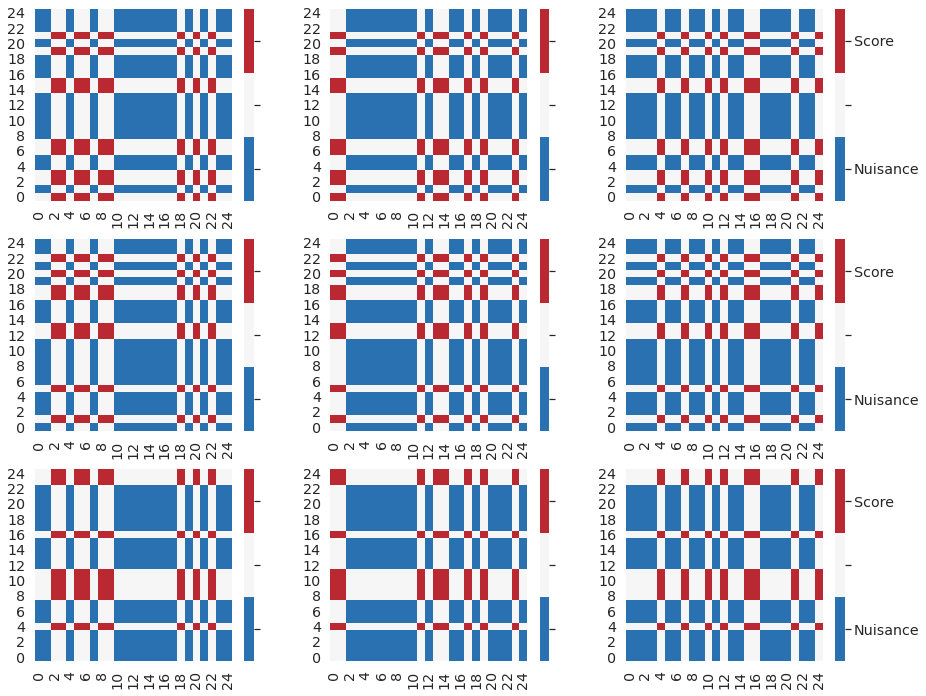

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



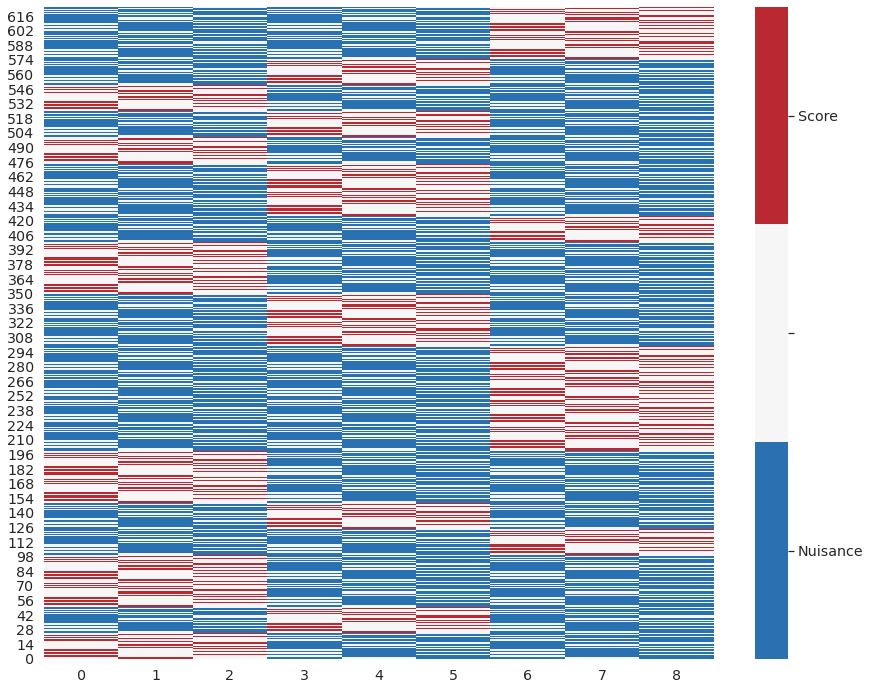

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])